# Integrated Prediction Analysis

Primary goal is to produce this figure: https://docs.google.com/presentation/d/1Dyud5Jzb4Xv-1UZgaJGZPSUKOwSQxdGPND4x7XssyN8/edit#slide=id.p

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../annotation_data")

In [3]:
from responsibility import *
from phase import *
from utils import *

In [4]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import os
import scipy
from collections import Counter
import math
import collections

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [6]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/"

In [7]:
vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw"
all_preds_filepath = os.path.join(vw_working_dir, "vw_all_preds.pkl")
resp_df = pd.read_pickle(all_preds_filepath)
#resp_df = resp_df[~resp_df.is_annotated]
len(resp_df)

157389

In [8]:
vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/phases/vw"
all_predictions_filepath = os.path.join(vw_working_dir, "vw_all_preds.pkl")
phase_df = pd.read_pickle(all_predictions_filepath)
#phase_df = phase_df[~phase_df.is_annotated]
len(phase_df)

158109

In [9]:
preds = pd.merge(resp_df, phase_df, how='inner', on=['site_id', 'journal_oid'])
preds.reset_index(drop=True, inplace=True)
preds.drop(columns=[col for col in preds.columns if col.endswith("_score")], inplace=True)
preds.head()

,conflict_status_x,is_annotated_x,journal_oid,responsibilities,site_id,behavior_changes_pred,compliance_pred,coordinating_support_pred,financial_management_pred,giving_back_pred,...,pretreatment_pred,treatment_pred,pretreatment_label,treatment_label,end_of_life_label,cured_label,pretreatment_pred_label,treatment_pred_label,end_of_life_pred_label,cured_pred_label
0,SINGLE USER,True,51be14196ca0041935009526,[],106710,0.566514,0.325545,0.519111,0.575837,0.596610,...,0.436907,0.083551,0,1,0,0,1,1,0,1
1,SINGLE USER,True,51be14196ca0041935009660,"[sharing_medical_info, compliance]",106710,0.514408,0.090461,0.481237,0.517510,0.540775,...,0.432912,0.097836,0,1,0,0,1,1,0,1
2,SINGLE USER,True,51be14196ca00419350098b4,[coordinating_support],106710,0.218780,0.138589,0.190549,0.213944,0.249954,...,0.241023,0.110258,0,1,0,0,1,1,1,1
3,SINGLE USER,True,51be14196ca00419350099e0,"[sharing_medical_info, compliance]",106710,0.290441,0.112008,0.306833,0.287974,0.309798,...,0.297044,0.076411,0,1,0,0,1,1,1,1
4,SINGLE USER,True,51be14196ca0041935009a62,"[coordinating_support, sharing_medical_info, c...",106710,0.363212,0.115526,0.195098,0.396739,0.401722,...,0.349263,0.084297,0,1,0,0,1,1,1,1


In [10]:
phase_cols = [phase_label + "_pred_label" for phase_label in phase_labels]
VALID_CLASS_LABELS = ([1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
                  [1,1,0,0],[0,1,1,0],[0,1,0,1],[0,0,0,0])

phase_label_map = {"pretreatment": 1,
                  "treatment": 2,
                  "cured": 3,
                  "end_of_life": 4,
                  "none": 0,
                  "invalid": -1,
                  "pretreatmenttreatment": 1.5,
                  "treatmentcured": 2.5,
                  "treatmentend_of_life": 3.5}
phase_labels_arr = np.array(phase_labels)

def get_phases(phase_label_values):
    phases = np.zeros(len(phase_label_values))
    for i, row in enumerate(phase_label_values):
        labels = phase_labels_arr[row == 1]
        key = "".join(labels)
        if key == "":
            code = phase_label_map["none"]
        elif key not in phase_label_map:
            code = phase_label_map['invalid']
        else:
            code = phase_label_map[key]
        phases[i] = code
    return phases

all_phases = []
for site_id, journals in preds.groupby(by='site_id', sort=False):
    phase_label_values = journals[phase_cols].values
    phases = get_phases(phase_label_values)
    all_phases.append(phases)
    #print(phases)
len(all_phases)

4947

In [11]:
all_minimal_phases = []
total_sites_with_smoothed_assignments = 0
total_smoothed_assignments = 0
for phases in all_phases:
    valid_phases_only = [phase for phase in phases if phase != -1 and phase != 0]
    if len(valid_phases_only) == 0:
        all_minimal_phases.append([])
        continue
    # now, "fix" triplets
    mp = valid_phases_only  # mp = minimal phases
    sp = np.zeros(len(mp))  # sp = smoothed phases
    sp[0] = mp[0]
    sp[-1] = mp[-1]
    replacements_made = 0
    for i in range(1, len(mp) - 1):
        if mp[i-1] != mp[i] and mp[i-1] == mp[i+1]:
            sp[i] = mp[i-1]
            mp[i] = mp[i-1]  # shouldn't be necessary, but fixes at least one strange edge case
            replacements_made += 1
        else:
            sp[i] = mp[i]
    minimal_phases = [key for key, group in itertools.groupby(sp)]
    all_minimal_phases.append(minimal_phases)
    if replacements_made > 0:
        total_sites_with_smoothed_assignments += 1
        total_smoothed_assignments += replacements_made
len(all_minimal_phases), total_sites_with_smoothed_assignments, total_smoothed_assignments

(4947, 2267, 5269)

In [12]:
phase_reps = [" > ".join([str(p) for p in minimal_phases]) for minimal_phases in all_minimal_phases]
common_patterns = Counter(phase_reps).most_common()
print(len(common_patterns))
common_patterns[:10]

452


[('2.0', 1715),
 ('1.5 > 2.0', 1279),
 ('1.0 > 2.0', 221),
 ('2.0 > 2.5', 163),
 ('1.5 > 2.0 > 2.5', 131),
 ('1.5 > 1.0 > 2.0', 86),
 ('1.5 > 2.0 > 1.5 > 2.0', 74),
 ('1.5 > 2.0 > 2.5 > 2.0', 73),
 ('2.0 > 2.5 > 2.0', 69),
 ('2.0 > 1.5 > 2.0', 57)]

In [13]:
mp_strings = ["|".join([str(p) for p in minimal_phases]) for minimal_phases in all_minimal_phases]
pattern_counter = Counter(mp_strings)
len(pattern_counter)

452

In [14]:
highest_pattern_count = max(pattern_counter.values())
highest_pattern_count

1715

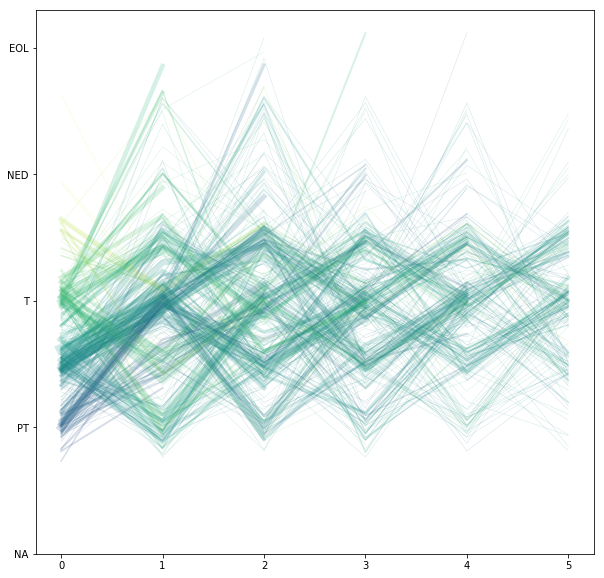

In [15]:
plotted = 0
plt.figure(figsize=(10,10))
for mp_string, _ in pattern_counter.most_common():
    minimal_phases = [float(token) for token in mp_string.split("|") if token != ""]
    if len(minimal_phases) > 6:
        minimal_phases = minimal_phases[:6]
    if len(minimal_phases) == 0:
        continue
    count = pattern_counter[mp_string]
    relative_count = np.log(count) / np.log(highest_pattern_count)
    minimal_phases = [m + np.random.normal(0, 0.1) for m in minimal_phases]
    starting_phase = minimal_phases[0]
    color = plt.get_cmap('viridis')(starting_phase / 3)
    plt.plot(range(len(minimal_phases)), minimal_phases, linewidth=relative_count * 10 + 0.5, linestyle="-", alpha=0.2, color=color)
    plotted += 1
plt.yticks([0, 1, 2, 3, 4], ["NA", "PT", "T", "NED", "EOL"])
plt.show()

In [16]:
pred_labels = preds[phase_cols].values

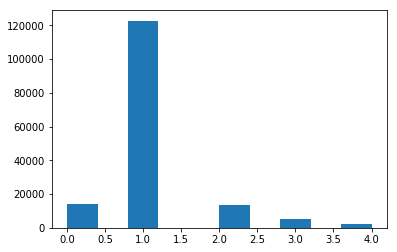

In [17]:
vals = np.apply_along_axis(lambda row: np.sum(row), 1, pred_labels)
plt.hist(vals)
plt.show()

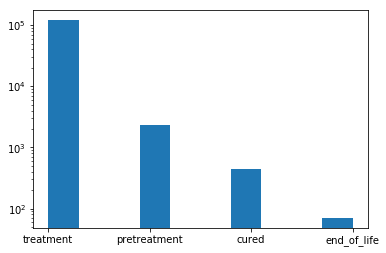

In [18]:
single_rows = np.apply_along_axis(lambda row: np.sum(row) == 1, 1, pred_labels)
plt.hist([phase_labels[row.argmax()] for row in pred_labels[single_rows]], log=True)
plt.show()

## Creating the smoothed predictions

In [19]:
phase_cols = [phase_label + "_pred_label" for phase_label in phase_labels]
VALID_CLASS_LABELS = ([1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
                  [1,1,0,0],[0,1,1,0],[0,1,0,1],[0,0,0,0])

phase_label_map = {"pretreatment": 1,
                  "treatment": 2,
                  "cured": 3,
                  "end_of_life": 4,
                  "none": 0,
                  "invalid": -1,
                  "pretreatmenttreatment": 1.5,
                  "treatmentcured": 2.5,
                  "treatmentend_of_life": 3.5}
phase_labels_arr = np.array(phase_labels)

def get_phases(phase_label_values):
    phases = np.zeros(len(phase_label_values))
    for i, row in enumerate(phase_label_values):
        labels = phase_labels_arr[row == 1]
        key = "".join(labels)
        if key == "":
            code = phase_label_map["none"]
        elif key not in phase_label_map:
            code = phase_label_map['invalid']
        else:
            code = phase_label_map[key]
        phases[i] = code
    return phases

def smooth_triplets(phases):
    cp = phases[:]  # cp = current phases
    sp = np.zeros(len(cp))  # sp = smoothed phases
    sp[0] = cp[0]
    sp[-1] = cp[-1]
    replacements_made = 0
    for i in range(1, len(cp) - 1):
        if cp[i-1] != cp[i] and cp[i-1] == cp[i+1]:
            sp[i] = cp[i-1]
            cp[i] = cp[i-1]  # shouldn't be necessary, but fixes at least one strange edge case
            replacements_made += 1
        else:
            sp[i] = cp[i]
    return sp

all_phases = []
preds['predicted_phase_label'] = None
preds['smoothed_phase_label'] = None
for site_id, journals in preds.groupby(by='site_id', sort=False):
    phase_label_values = journals[phase_cols].values
    phases = get_phases(phase_label_values)
    preds.loc[journals.index, 'predicted_phase_label'] = phases
    smoothed_phases = smooth_triplets(phases)
    preds.loc[journals.index, 'smoothed_phase_label'] = smoothed_phases
    all_phases.append(phases)
len(all_phases)

all_smoothed_phases = []
no_valid_phase_count = 0
total_sites_with_smoothed_assignments = 0
total_smoothed_assignments = 0
for phases in all_phases:
    valid_phases_only = [phase for phase in phases if phase != -1 and phase != 0]
    if len(valid_phases_only) == 0:
        no_valid_phase_count += 1
        all_smoothed_phases.append([])
        continue
    # now, "fix" triplets
    cp = phases[:]  # cp = current phases
    sp = np.zeros(len(cp))  # sp = smoothed phases
    sp[0] = cp[0]
    sp[-1] = cp[-1]
    replacements_made = 0
    for i in range(1, len(cp) - 1):
        if cp[i-1] != cp[i] and cp[i-1] == cp[i+1]:
            sp[i] = cp[i-1]
            cp[i] = cp[i-1]  # shouldn't be necessary, but fixes at least one strange edge case
            replacements_made += 1
        else:
            sp[i] = cp[i]
    smoothed_phases = sp
    all_smoothed_phases.append(smoothed_phases)
    if replacements_made > 0:
        total_sites_with_smoothed_assignments += 1
        total_smoothed_assignments += replacements_made
len(all_smoothed_phases), total_sites_with_smoothed_assignments, total_smoothed_assignments, no_valid_phase_count

(4947, 0, 0, 20)

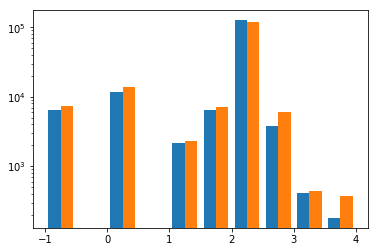

[(2.0, 126322),
 (0.0, 11778),
 (1.5, 6386),
 (-1.0, 6374),
 (2.5, 3787),
 (1.0, 2152),
 (3.0, 405),
 (3.5, 110),
 (4.0, 70)]

In [20]:
plt.hist([preds.smoothed_phase_label.tolist(), preds.predicted_phase_label.tolist()], log=True)
plt.show()
Counter(preds.smoothed_phase_label).most_common()

In [23]:
VALID_TRANSITIONS = [(1, 2), (2, 3), (2, 4)] + [(0,i) for i in [1,2,3,4]] + [(i,0) for i in [1,2,3,4]] + [(i,i) for i in [0,1,2,3,4]]

invalid_transition_sites = 0
invalid_transition_journals = 0
invalid_update_in_transition_count = 0
for site_id, journals in preds.groupby(by='site_id', sort=False):
    invalid_transitions = 0
    for i in range(len(journals) - 1):
        cur = journals.iloc[i].smoothed_phase_label
        nxt = journals.iloc[i+1].smoothed_phase_label
        cur_f = math.floor(cur)
        cur_r = round(cur)
        nxt_f = math.floor(nxt)
        nxt_r = round(nxt)
        if (cur_f, nxt_f) not in VALID_TRANSITIONS \
            or (cur_r, nxt_f) not in VALID_TRANSITIONS \
            or (cur_f, nxt_r) not in VALID_TRANSITIONS \
            or (cur_r, nxt_r) not in VALID_TRANSITIONS:
            invalid_transitions += 1
            if cur == -1 or nxt == -1:
                invalid_update_in_transition_count += 1
            #print(cur, nxt)
    if invalid_transitions > 0:
        invalid_transition_sites += 1
        invalid_transition_journals += invalid_transitions
    #print(invalid_transitions / len(journals))
invalid_transition_sites, invalid_transition_sites / len(set(preds.site_id)), \
invalid_transition_journals, invalid_transition_journals / (len(preds) - len(set(preds.site_id)))

(2792, 0.5643824540125328, 12214, 0.0801249040587259)

In [24]:
(invalid_transition_journals - invalid_update_in_transition_count) / (len(preds) - len(set(preds.site_id)))

0.026653633960258993

In [25]:
VALID_TRANSITIONS = [(1, 2), (2, 3), (2, 4)] + [(0,i) for i in [1,2,3,4]] + [(i,0) for i in [1,2,3,4]] + [(i,i) for i in [0,1,2,3,4]]

invalid_transition_sites = 0
invalid_transition_journals = 0
invalid_update_in_transition_count = 0
for site_id, journals in preds.groupby(by='site_id', sort=False):
    invalid_transitions = 0
    for i in range(len(journals) - 1):
        cur = journals.iloc[i].predicted_phase_label
        nxt = journals.iloc[i+1].predicted_phase_label
        cur_f = math.floor(cur)
        cur_r = round(cur)
        nxt_f = math.floor(nxt)
        nxt_r = round(nxt)
        if (cur_f, nxt_f) not in VALID_TRANSITIONS \
            or (cur_r, nxt_f) not in VALID_TRANSITIONS \
            or (cur_f, nxt_r) not in VALID_TRANSITIONS \
            or (cur_r, nxt_r) not in VALID_TRANSITIONS:
            invalid_transitions += 1
            if cur == -1 or nxt == -1:
                invalid_update_in_transition_count += 1
            #print(cur, nxt)
    if invalid_transitions > 0:
        invalid_transition_sites += 1
        invalid_transition_journals += invalid_transitions
    #print(invalid_transitions / len(journals))
invalid_transition_sites, invalid_transition_sites / len(set(preds.site_id)), \
invalid_transition_journals, invalid_transition_journals / (len(preds) - len(set(preds.site_id))), \
(invalid_transition_journals - invalid_update_in_transition_count) / (len(preds) - len(set(preds.site_id)))

(3181, 0.6430159692743077, 15475, 0.10151734815038344, 0.03221002774916851)

## Compute phase transition proportions

In [26]:
import collections
end_of_site = 10
transition_counts = collections.defaultdict(int)

for site_id, journals in preds.groupby(by='site_id', sort=False):
    prev_phase = journals.iloc[0].smoothed_phase_label
    for i in range(1, len(journals)):
        curr = journals.iloc[i]
        curr_phase = curr.smoothed_phase_label
        if (np.abs(curr_phase - prev_phase) == 0.5 or (prev_phase == 3.5 and curr_phase == 2)) and round(prev_phase) != prev_phase:
            # we favor concrete phases over transition phases when seeking for transitions
            prev_phase = curr_phase
            continue
        elif curr_phase != prev_phase and curr_phase != -1:  # this is a transition!
            transition_counts[(prev_phase, curr_phase)] += 1
            prev_phase = curr_phase
    transition_counts[(prev_phase, end_of_site)] += 1

transition_counts

defaultdict(int,
            {(-1.0, 2.0): 739,
             (2.0, 10): 3566,
             (1.0, 2.0): 545,
             (2.0, 2.5): 1567,
             (3.0, 10): 72,
             (2.0, 3.0): 73,
             (2.0, 1.5): 934,
             (1.0, 0.0): 247,
             (0.0, 1.5): 208,
             (2.0, 0.0): 2788,
             (0.0, 2.0): 2679,
             (0.0, 2.5): 321,
             (0.0, 1.0): 295,
             (0.0, 10): 704,
             (2.0, 4.0): 30,
             (4.0, 10): 34,
             (1.0, 1.5): 229,
             (3.0, 2.0): 48,
             (0.0, 3.0): 70,
             (-1.0, 1.5): 638,
             (1.5, 2.5): 128,
             (1.0, 3.0): 3,
             (3.0, 1.0): 1,
             (2.5, 10): 453,
             (1.0, 10): 19,
             (2.5, 1.5): 212,
             (2.5, 0.0): 271,
             (1.5, 0.0): 419,
             (2.0, 3.5): 75,
             (3.5, 10): 20,
             (3.5, 1.5): 15,
             (2.0, 1.0): 150,
             (3.5, 0.0): 17,
         

In [34]:

print(f"{'From':20}  {'To':20}  {'Raw':>4}  {'%':>5}")
print("="*55)
for phase_label, codes in zip(phase_labels, ((1.0, 1.5), (1.5, 2.0, 2.5, 3.5), (3.5, 4.0), (2.5, 3.0))):
    phase_counts = []
    for other_phase_label, other_codes in zip(phase_labels, ((1, 1.5), (1.5, 2, 2.5, 3.5), (3.5, 4), (2.5, 3))):
        count = 0
        for code in codes:
            for other_code in other_codes:
                if code == other_code or phase_label == other_phase_label or \
                        np.abs(code - other_code) == 0.5 or \
                        (code == 2.5 and other_code == 3.5) or \
                        (code == 3.5 and other_code == 2.5):
                    continue
                count += transition_counts[(code, other_code)]
        phase_counts.append(count)
    end_of_site_count = 0
    for code in codes:
        end_of_site_count += transition_counts[(code, end_of_site)]
    
    total_count = end_of_site_count
    for code in codes:
        for other_code in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
            if other_code in codes:
                continue
            total_count += transition_counts[(code, other_code)]
    
    for i, other_phase_label in enumerate(phase_labels):
        print(f"{phase_label:20}  {other_phase_label:20}  {phase_counts[i]:4}  {phase_counts[i] / total_count * 100:5.2f}")
    print(f"{phase_label:20}  {'END OF SITE':20}  {end_of_site_count:4}  {end_of_site_count / total_count * 100:5.2f}")
        


From                  To                     Raw      %
pretreatment          pretreatment             0   0.00
pretreatment          treatment              690  88.01
pretreatment          end_of_life              6   0.77
pretreatment          cured                  143  18.24
pretreatment          END OF SITE             90  11.48
treatment             pretreatment           391   8.93
treatment             treatment                0   0.00
treatment             end_of_life            110   2.51
treatment             cured                  202   4.61
treatment             END OF SITE           4110  93.88
end_of_life           pretreatment            17  20.99
end_of_life           treatment               16  19.75
end_of_life           end_of_life              0   0.00
end_of_life           cured                    0   0.00
end_of_life           END OF SITE             54  66.67
cured                 pretreatment           234  28.75
cured                 treatment              268

## Compute responsibility variances at different phases

In [28]:
preds_subset = preds[preds.smoothed_phase_label >= 1]
preds_subset = preds[preds.smoothed_phase_label.isin([1, 2, 3, 4])]
len(preds_subset) / len(preds)

0.8193272505464342

In [29]:
global_proportions = []
for resp_label in high_irr_responsibility_labels:
    resp_count = np.sum(preds_subset[resp_label + "_pred_label"] == 1)
    resp_proportion = resp_count / len(preds_subset)
    global_proportions.append(resp_proportion)
global_proportions = np.array(global_proportions)
global_proportions

array([0.17361127, 0.913206  , 0.87637748, 0.02694088, 0.02874004,
       0.03821666])

In [40]:
for phase_label, codes in zip(phase_labels, ((1.0, 1.5), (1.5, 2.0, 2.5, 3.5), (3.5, 4.0), (2.5, 3.0))):
    phase_subset = preds_subset[preds_subset.smoothed_phase_label.isin(codes)]
    other_subset = preds_subset[~preds_subset.smoothed_phase_label.isin(codes)]
    phase_proportions = []
    other_proportions = []
    for resp_label in high_irr_responsibility_labels:
        # Compute for this phase
        resp_count = np.sum(phase_subset[resp_label + "_pred_label"] == 1)
        resp_proportion = resp_count / len(phase_subset)
        phase_proportions.append(resp_proportion)
        # Compute for all other phases
        resp_count = np.sum(other_subset[resp_label + "_pred_label"] == 1)
        resp_proportion = resp_count / len(other_subset)
        other_proportions.append(resp_proportion)
    phase_proportions = np.array(phase_proportions)
    diffs = phase_proportions - global_proportions
    #diffs = phase_proportions - other_proportions
    print(phase_label)
    for resp_label, prop in zip(high_irr_responsibility_codes, phase_proportions - other_proportions):
        print(f"{resp_label} {prop * 100:.2f}")
    print(list(zip(high_irr_responsibility_codes, phase_proportions)), len(phase_subset))
    #print("Global diffs:", phase_proportions - global_proportions)
    #print("Relative diffs:", phase_proportions - other_proportions)
    print()

pretreatment
CS 0.73
SM 4.57
CP 6.95
FM -1.18
GB -1.32
BC -2.28
[('CS', 0.18076208178438663), ('SM', 0.95817843866171), ('CP', 0.9447026022304833), ('FM', 0.01533457249070632), ('GB', 0.015799256505576207), ('BC', 0.015799256505576207)] 2152

treatment
CS -1.09
SM -3.46
CP -4.61
FM 0.85
GB 0.80
BC 1.49
[('CS', 0.1733902249806051), ('SM', 0.9125013853485537), ('CP', 0.8754373743290955), ('FM', 0.027113250265195295), ('GB', 0.028902328968825698), ('BC', 0.03852060607020155)] 126322

end_of_life
CS 38.37
SM -2.75
CP 5.22
FM 8.74
GB 14.28
BC 11.90
[('CS', 0.5571428571428572), ('SM', 0.8857142857142857), ('CP', 0.9285714285714286), ('FM', 0.11428571428571428), ('GB', 0.17142857142857143), ('BC', 0.15714285714285714)] 70

cured
CS -3.55
SM -1.45
CP -7.91
FM -0.72
GB -0.65
BC 0.38
[('CS', 0.1382716049382716), ('SM', 0.8987654320987655), ('CP', 0.7975308641975308), ('FM', 0.019753086419753086), ('GB', 0.022222222222222223), ('BC', 0.04197530864197531)] 405



In [31]:
global_proportions

array([0.17361127, 0.913206  , 0.87637748, 0.02694088, 0.02874004,
       0.03821666])

In [32]:
high_irr_responsibility_labels

['coordinating_support',
 'sharing_medical_info',
 'compliance',
 'financial_management',
 'giving_back',
 'behavior_changes']

## Save Dataframe

In [33]:
integrated_preds_filepath = os.path.join(working_dir, "integrated_preds.pkl")
preds.to_pickle(integrated_preds_filepath)
print("Finished.")

Finished.


### Misc

In [23]:
def format_float(val):
    if val >= 0 and val < 0.995:
        return "{:.2f}".format(val)[1:]
    elif val >= 0.995:
        return "1"
    else:
        raise ValueError("Negatives not handled.")
        
format_float(0.997)

'1'

In [ ]:
responsibility_label_to_code_map

In [25]:
eol_site_file = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/naray114/prateek_eol_sites.txt"
eol_sites = []
with open(eol_site_file, 'r') as infile:
    infile.readline()
    for line in infile:
        site_id = int(line.strip())
        eol_sites.append(site_id)
len(eol_sites)

63

In [31]:
phase_a = phase_df[phase_df.is_annotated]
total_annotated_journals = len(phase_a)
total_annotated_sites = len(set(phase_a.site_id))

In [28]:
eol_annotated_sites = len(eol_sites)
eol_annotated_journals = len(phase_a[phase_a.site_id.isin(eol_sites)])
eol_annotated_sites, eol_annotated_journals

(63, 3852)

In [29]:
phase_uncertainty_file = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/active_learning/uncertainty_sampled_sites_entropy.txt"
uncertainty_sites = []
with open(phase_uncertainty_file, 'r') as infile:
    for line in infile:
        site_id = int(line.strip())
        uncertainty_sites.append(site_id)
len(uncertainty_sites)

28

In [30]:
uncertainty_annotated_sites = len(uncertainty_sites)
uncertainty_annotated_journals = len(phase_a[phase_a.site_id.isin(uncertainty_sites)])
uncertainty_annotated_sites, uncertainty_annotated_journals

(28, 278)

In [32]:
random_annotated_sites = total_annotated_sites - uncertainty_annotated_sites - eol_annotated_sites
random_annotated_journals = len(phase_a[~phase_a.site_id.isin(uncertainty_sites + eol_sites)])
random_annotated_sites, random_annotated_journals

(109, 2791)

In [35]:
resp_a = resp_df[resp_df.is_annotated]
len(resp_a) - 34, len(set(resp_a.site_id)) - 23

(1857, 59)